# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Признаки**
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя


**Целевой признак**
- Price — цена (евро)

## Подготовка данных

Загрузим библиотеки и данные

In [1]:
!pip install category_encoders
!pip install lightgbm

     -------------------------------------- 69.1/69.1 KB 754.0 kB/s eta 0:00:00
  Using cached lightgbm-3.3.2-py3-none-win_amd64.whl (1.0 MB)


In [2]:
import time
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import category_encoders as ce
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error as mse, make_scorer

from sklearn.dummy import DummyRegressor
from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression

In [3]:
try:
    df = pd.read_csv('autos.csv')
except:
    df = pd.read_csv('/datasets/autos.csv')

Посмотрим на наши данные

In [4]:
display(df.info(), df.head(), df.describe(), 'Процент пропусков:', (df.isna().sum() / df.count()).sort_values(ascending=False))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


'Процент пропусков:'

NotRepaired          0.251237
VehicleType          0.118310
FuelType             0.102326
Gearbox              0.059285
Model                0.058880
DateCrawled          0.000000
Price                0.000000
RegistrationYear     0.000000
Power                0.000000
Kilometer            0.000000
RegistrationMonth    0.000000
Brand                0.000000
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64

Мы видим ряд проблем которые нужно решить:
- [x] Пустой столбец с информацией о кол-ве изображений
- [x] Большое кол-во пропусков в колонках с типом кузова, типом коробки передач, типом топлива, моделью и данными о ремонте
- [x] Нулевые значения в колонках с месяцем регистрации авто, мощностью и ценой
- [x] Аномальные значения в колонках с годом регистрации авто и мощностью 

Приведем названия столбцов к нижнему регистру

In [5]:
df.columns = ['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type', 'brand',
       'not_repaired', 'date_created', 'number_of_pictures', 'postal_code',
       'last_seen']

Удалим ненужные столбцы

In [6]:
select = ['date_crawled', 'postal_code', 'date_created',
            'last_seen', 'number_of_pictures']
df = df.drop(columns=select)

Заполним пропуски в категориальных данных

In [7]:
for i in ['not_repaired', 'vehicle_type', 'model', 'fuel_type', 'gearbox']:
    print(f'{i}\n', df[i].value_counts())

not_repaired
 no     247161
yes     36054
Name: not_repaired, dtype: int64
vehicle_type
 sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: vehicle_type, dtype: int64
model
 golf                  29232
other                 24421
3er                   19761
polo                  13066
corsa                 12570
                      ...  
i3                        8
serie_3                   4
rangerover                4
range_rover_evoque        2
serie_1                   2
Name: model, Length: 250, dtype: int64
fuel_type
 petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: fuel_type, dtype: int64
gearbox
 manual    268251
auto       66285
Name: gearbox, dtype: int64


Признаки c данными о ремонте, типом кузова и моделью являются не очевидными, заменим пропуски на индикаторные значения 

In [8]:
fill_columns = ['not_repaired', 'vehicle_type', 'model']
for i in fill_columns:
    df[i].fillna('n/a', inplace=True)
df[fill_columns].isna().sum()

not_repaired    0
vehicle_type    0
model           0
dtype: int64

Заменим пропущенные значения в типе топлива и коробках передач на самые популярные

In [9]:
df['fuel_type'].fillna('petrol', inplace=True)
df['gearbox'].fillna('manual', inplace=True)
df[['fuel_type', 'gearbox']].isna().sum()

fuel_type    0
gearbox      0
dtype: int64

Удалим нулевые значения из месяца регистрации 

In [10]:
df = df[df['registration_month'] > 0]

Сделаем срез с адекватными годами регистрации 

<AxesSubplot:>

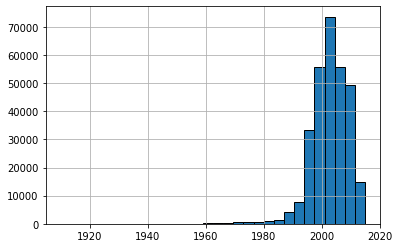

In [11]:
df = df[(df['registration_year'] > 1900) & (df['registration_year'] < 2016)]
df['registration_year'].hist(bins=30, ec='black')

Посмотрим на данные о мощности

In [12]:
df.groupby(by='model').median().sort_values(by='power')

,price,registration_year,power,kilometer,registration_month
model,,,,,
601,1399.0,1987.0,26.0,50000.0,6.0
samara,475.0,1998.0,30.0,125000.0,7.0
kaefer,6000.0,1974.0,34.0,90000.0,5.0
move,500.0,1999.0,42.5,150000.0,6.0
lupo,1300.0,2000.0,50.0,150000.0,6.0
...,...,...,...,...,...
911,14955.0,1999.0,300.0,150000.0,5.0
cl,7375.0,2002.0,306.0,150000.0,7.0
6er,14500.0,2004.0,333.0,150000.0,6.0


<AxesSubplot:>

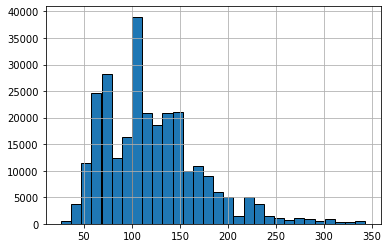

In [13]:
df = df[(df['power'] < 344) & (df['power'] > 25)]
df['power'].hist(bins=30, ec='black')

Посмотрим на распределение цен

In [14]:
df.groupby(by='model').median().sort_values(by='price')

,price,registration_year,power,kilometer,registration_month
model,,,,,
elefantino,200.0,1999.0,60.0,150000.0,4.0
move,599.5,1999.0,50.0,150000.0,6.0
escort,600.0,1996.0,90.0,150000.0,5.0
lanos,650.0,2000.0,75.0,150000.0,8.0
145,750.0,1999.0,103.0,150000.0,5.0
...,...,...,...,...,...
q5,16499.0,2010.0,211.0,125000.0,6.0
a5,16650.0,2009.0,190.0,150000.0,7.0
glk,17949.5,2009.0,170.0,150000.0,7.0


Сделаем срез до 200 евро 

<AxesSubplot:>

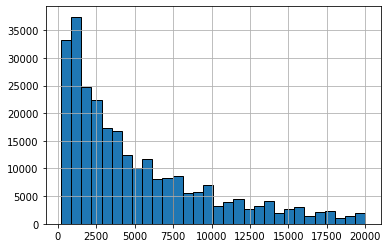

In [15]:
df =  df[df['price'] > 199]
df['price'].hist(bins=30, ec='black')

Проверим данные на дубликаты

In [16]:
display(df.duplicated().sum(), df[df.duplicated()])

22769

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired
3551,1670,sedan,1999,manual,75,golf,150000,8,petrol,volkswagen,no
3786,2999,sedan,2002,manual,101,golf,150000,6,gasoline,volkswagen,no
3907,500,small,1999,manual,55,corsa,150000,12,petrol,opel,no
4134,18750,sedan,2014,manual,150,golf,20000,9,gasoline,volkswagen,no
4222,14500,wagon,2007,manual,140,a6,100000,3,gasoline,audi,no
...,...,...,...,...,...,...,...,...,...,...,...
354320,1500,sedan,1999,manual,75,golf,150000,4,petrol,volkswagen,n/a
354325,12800,convertible,1991,manual,211,other,150000,7,petrol,porsche,no
354333,13850,wagon,2012,manual,156,accord,125000,10,petrol,honda,no
354352,6500,sedan,2003,auto,145,e_klasse,150000,3,gasoline,mercedes_benz,no


In [17]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

Перейдем к обучению моделей

## Обучение моделей

Сделаем свой скорер

In [18]:
def rmse(y, predictions):
    return mse(y, predictions) ** .5

rmse_score = make_scorer(rmse, greater_is_better=False)

In [19]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

Закодируем данные и разобьем на обучающую и тестовую выборки

In [20]:
X = df.drop('price', axis=1)
y = df['price']

In [21]:
cbe_encoder = ce.cat_boost.CatBoostEncoder()
cbe_encoder.fit(X, y)
X_enc = cbe_encoder.transform(X)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.2)
X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(X_enc, y, random_state=42, test_size=.2)


In [23]:
cat_features = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired']

Создадим функцию подсчета времени

In [24]:
def model_time(model, X_train, y_train, X_test, y_test):
    start = time.time()
    model.fit(X_train, y_train)
    fit_time = time.time() - start
    start = time.time()
    pred = model.predict(X_test)
    pred_time = time.time() - start
    score = rmse(pred, y_test)
    return fit_time, pred_time, score

res = []

Обучим модели

### DummyRegressor

In [25]:
dummy = DummyRegressor(strategy="mean", ).fit(X_train_e, y_train_e)
res.append(model_time(dummy, X_train_e, y_train_e, X_test_e, y_test_e))
rmse(y_test, dummy.predict(X_test))

4660.980179941895

### LGBMRegressor

In [26]:
estim = LGBMRegressor(boosting_type='gbdt', random_state=42)

params = {
    'n_estimators': [60, 150],
    'num_leaves': [21, 31, 41],
    'learning_rate': np.logspace(-2, 5),
}

grid_lgbm = GridSearchCV(estimator=estim, param_grid=params, cv=cv, \
                         scoring=rmse_score, n_jobs=-1)

X[cat_features] = X[cat_features].astype('category')
X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(X, y, random_state=42, test_size=.2)

In [27]:
%%time
grid_lgbm.fit(X_train_l, y_train_l)

CPU times: total: 27.2 s
Wall time: 10min 13s


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LGBMRegressor(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': array([1.00000000e-02, 1.38949549e-02, 1.93069773e-02, 2.68269580e-02,
       3.72759372e-02, 5.17947468e-02, 7.19685673e-02, 1.00000000e-01,
       1.38949549e-01, 1.93069773e-01, 2.68269580e-01, 3.72759372e-01,
       5.17947468e-01, 7.1968...
       3.72759372e+02, 5.17947468e+02, 7.19685673e+02, 1.00000000e+03,
       1.38949549e+03, 1.93069773e+03, 2.68269580e+03, 3.72759372e+03,
       5.17947468e+03, 7.19685673e+03, 1.00000000e+04, 1.38949549e+04,
       1.93069773e+04, 2.68269580e+04, 3.72759372e+04, 5.17947468e+04,
       7.19685673e+04, 1.00000000e+05]),
                         'n_estimators': [60, 150],
                         'num_leaves': [21, 31, 41]},
             scoring=make_scorer(rmse, greater_is_better=False))

In [28]:
res.append(model_time(grid_lgbm.best_estimator_, X_train_l, y_train_l, X_test_l, y_test_l))
display(grid_lgbm.best_params_, grid_lgbm.best_score_)

{'learning_rate': 0.19306977288832497, 'n_estimators': 150, 'num_leaves': 41}

-1536.2956750604712

### CatBoostRegressor

In [29]:
cb = CatBoostRegressor(loss_function='RMSE', silent=True, random_state=42)

params = {
    'n_estimators': [60, 150],
    'learning_rate': [0.1],
    'depth': [3, 5]
}

train_pool = Pool(X_train, y_train, cat_features=cat_features) 
test_pool = Pool(X_test, y_test, cat_features=cat_features)

cb.grid_search(params, train_pool, cv=cv, verbose=False)


bestTest = 1941.657147
bestIteration = 59


bestTest = 1791.387233
bestIteration = 149


bestTest = 1819.047239
bestIteration = 59


bestTest = 1698.870313
bestIteration = 149

Training on fold [0/5]

bestTest = 1712.660351
bestIteration = 149

Training on fold [1/5]

bestTest = 1698.196987
bestIteration = 149

Training on fold [2/5]

bestTest = 1680.295231
bestIteration = 149

Training on fold [3/5]

bestTest = 1698.444425
bestIteration = 149

Training on fold [4/5]

bestTest = 1700.725252
bestIteration = 149



{'params': {'depth': 5, 'iterations': 150, 'learning_rate': 0.1},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
    

In [30]:
start = time.time()
cb.fit(train_pool)
fit_time = time.time() - start
start = time.time()
pred = cb.predict(X_test)
pred_time = time.time() - start
score = rmse(pred, y_test)
res.append([fit_time, pred_time, score])

In [31]:
pred = %time cb.predict(X_test)
rmse(y_test, pred)

CPU times: total: 125 ms
Wall time: 139 ms


1699.1641965355122

### LinearRegression

In [32]:
estim = LinearRegression()

params = {
    'fit_intercept': [True, False],
    'normalize': [True, False]
}

grid_lr = GridSearchCV(estimator=estim, param_grid=params, cv=cv, \
                       scoring=rmse_score, n_jobs=-1)

In [33]:
%%time
grid_lr.fit(X_train_e, y_train_e)

CPU times: total: 328 ms
Wall time: 1.77 s


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LinearRegression(), n_jobs=-1,
             param_grid={'fit_intercept': [True, False],
                         'normalize': [True, False]},
             scoring=make_scorer(rmse, greater_is_better=False))

In [34]:
res.append(model_time(grid_lr.best_estimator_, X_train_e, y_train_e, X_test_e, y_test_e))
display(grid_lr.best_params_, grid_lr.best_score_)

{'fit_intercept': True, 'normalize': False}

-2726.174645677479

## Анализ моделей

In [35]:
result = pd.DataFrame(columns=['fit_time', 'pred_time', 'score'], data=res)    
result.index = ['dummy', 'lgbm', 'catboost', 'lr']
result


,fit_time,pred_time,score
dummy,0.000000,0.001007,4660.980180
lgbm,1.166880,0.296205,1533.980264
catboost,8.189556,0.133343,1699.164197
lr,0.063856,0.019884,2718.270639


## Вывод

В ходе исследования были построены и проанализированы три модели - две модели с градиентным бустингом - LGBMRegressor и CatBoostRegressor, а так же более легковесную LinearRegression. Для сравнения использовал DummyRegressor. Модель LGBMRegressor является фаворитом по времени обучения, предсказания и оценки RMSE.